# PoseNet Demo

This notebook contains code to convert `PoseNet` as implemented in "Learning to Estimate 3D Hand Pose from Single RGB Images" by Zimmerman et al. Their project is available at [https://github.com/lmb-freiburg/hand3d].

In [1]:
import os
import sys
import math

import torch
import torchvision
import torch.nn.functional as F
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

model_path = os.path.abspath(os.path.join('..'))
if model_path not in sys.path:
    sys.path.append(model_path)
    
from colorhandpose3d.model.HandSegNet import HandSegNet
from colorhandpose3d.model.PoseNet import PoseNet
from colorhandpose3d.utils.general import *

## Initialize PoseNet model

First, intialize the PyTorch implementation of PoseNet.

In [2]:
posenet = PoseNet()

## Import weights from Tensorflow model

Zimmerman et al. saved their model's weights in `pickle` format.

In [31]:
file_name = '/home/ajdillhoff/Downloads/ColorHandPose3D_data_v3/weights/posenet3d-rhd-stb-slr-finetuned.pickle'
session = tf.Session()
exclude_var_list = list()

# read from pickle file
with open(file_name, 'rb') as fi:
    weight_dict = pickle.load(fi)
    weight_dict = {k: v for k, v in weight_dict.items() if not any([x in k for x in exclude_var_list])}
    
keys = [k for k, v in weight_dict.items() if 'PoseNet2D' in k]
keys.sort()

# [print(k, weight_dict[k].shape) for k in keys]
    
for name, module in posenet.named_children():
    key = 'PoseNet2D/{0}/'.format(name)
    if key + 'biases' in weight_dict:
        b = torch.Tensor(weight_dict[key + 'biases'])
        w = torch.Tensor(weight_dict[key + 'weights'])
        w = w.permute((3, 2, 1, 0))
        module.weight.data = w
        module.bias.data = b
        
torch.save(posenet.state_dict(), '/home/ajdillhoff/dev/projects/colorhandpose3d-pytorch/saved/posenet.pth.tar')

## Hand Segmentation

Before identifying the keypoints, the hand needs to be segmented from the original image.

In [32]:
handsegnet = HandSegNet()
handsegnet.load_state_dict(torch.load('/home/ajdillhoff/dev/projects/colorhandpose3d-pytorch/saved/handsegnet.pth.tar'))

In [33]:
def visualize_mask(img, mask):
    plt.figure(figsize=(16, 16))
    plt.subplot(121)
    plt.imshow(img)
    
    plt.subplot(122)
    plt.imshow(mask)
    plt.show()

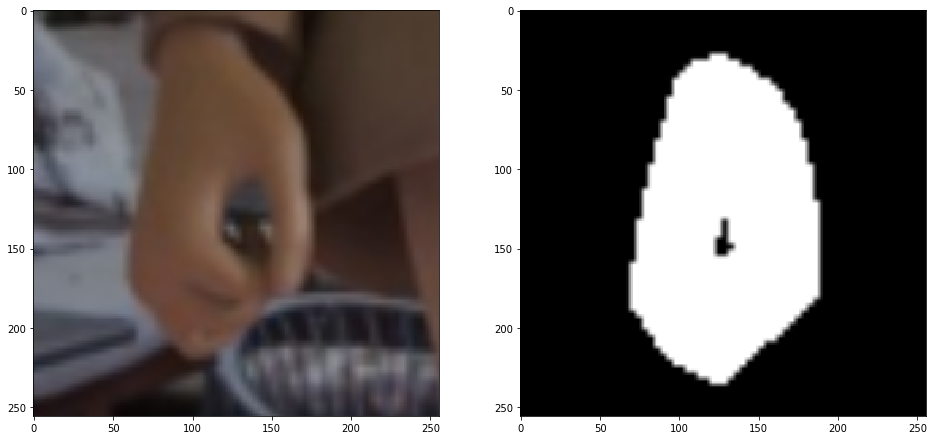

In [58]:
transform0 = torchvision.transforms.ToPILImage()
transform1 = torchvision.transforms.ToTensor()
transform2 = torchvision.transforms.Resize(256)
img = Image.open('/home/ajdillhoff/Downloads/RHD_v1-1/RHD_published_v2/training/color/00007.png')
sample_original = transform1(transform2(img)).unsqueeze(0)
sample = sample_original - 0.5

# Run through network
output = handsegnet.forward(sample)

# Calculate single highest scoring object
test_output = single_obj_scoremap(output, 21)

# Crop and resize
centers, bbs, crops = calc_center_bb(test_output)
crops = crops.to(torch.float32)
crop_size = 256

crops[0] *= 1.25
scale_crop = min(max(crop_size / crops[0], 0.25), 5.0)
image_crop = crop_image_from_xy(sample_original, centers, crop_size, scale_crop)
mask_crop = crop_image_from_xy(test_output, centers, crop_size, scale_crop)

# also take a sample crop with mean subtracted
sample_crop = crop_image_from_xy(sample, centers, crop_size, scale_crop)

img = transform0(image_crop[0])
mask_img = transform0(mask_crop[0])
visualize_mask(img, mask_img)

## Run output through PoseNet

The cropped hand image is now passed through `PoseNet` to output the hand keypoint maps.

In [59]:
def visualize_heatmaps(heatmaps):
    """Visualize all 21 heatmaps in a 7x3 grid"""
    
    fig, axes = plt.subplots(7, 3, figsize=(16, 16))
    
    t = torchvision.transforms.ToPILImage()
    
    for i in range(heatmaps.shape[0]):
        img_row = int(i / 3)
        img_col = i % 3
        
        heatmap = heatmaps[i].unsqueeze(0)
        # normalize
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        heatmap = t(heatmap)
        
        axes[img_row, img_col].imshow(heatmap)

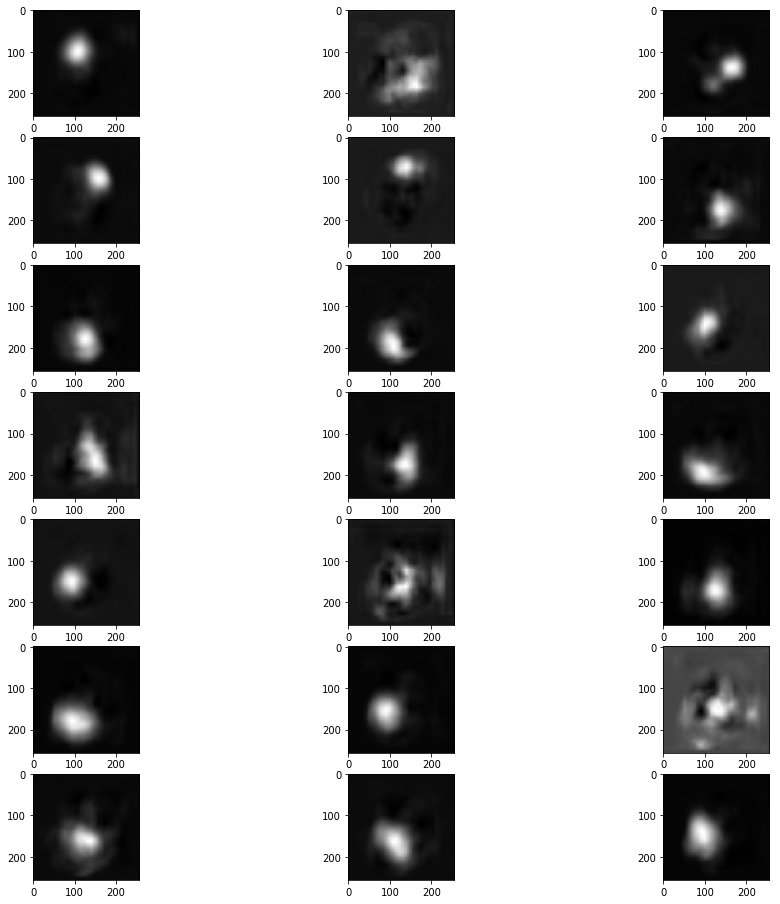

In [61]:
pose_out = posenet(sample_crop)
heatmaps = F.interpolate(pose_out, 256, mode='bilinear', align_corners=False)
visualize_heatmaps(heatmaps[0])

## Detect Keypoints

The original authors include a function for detecting the keypoints using the scoremaps.

In [62]:
def plot_hand(coords_hw, axis, color_fixed=None, linewidth='1'):
    """ Plots a hand stick figure into a matplotlib figure. """
    colors = np.array([[0., 0., 0.5],
                       [0., 0., 0.73172906],
                       [0., 0., 0.96345811],
                       [0., 0.12745098, 1.],
                       [0., 0.33137255, 1.],
                       [0., 0.55098039, 1.],
                       [0., 0.75490196, 1.],
                       [0.06008855, 0.9745098, 0.90765338],
                       [0.22454143, 1., 0.74320051],
                       [0.40164453, 1., 0.56609741],
                       [0.56609741, 1., 0.40164453],
                       [0.74320051, 1., 0.22454143],
                       [0.90765338, 1., 0.06008855],
                       [1., 0.82861293, 0.],
                       [1., 0.63979666, 0.],
                       [1., 0.43645606, 0.],
                       [1., 0.2476398, 0.],
                       [0.96345811, 0.0442992, 0.],
                       [0.73172906, 0., 0.],
                       [0.5, 0., 0.]])

    # define connections and colors of the bones
    bones = [((0, 4), colors[0, :]),
             ((4, 3), colors[1, :]),
             ((3, 2), colors[2, :]),
             ((2, 1), colors[3, :]),

             ((0, 8), colors[4, :]),
             ((8, 7), colors[5, :]),
             ((7, 6), colors[6, :]),
             ((6, 5), colors[7, :]),

             ((0, 12), colors[8, :]),
             ((12, 11), colors[9, :]),
             ((11, 10), colors[10, :]),
             ((10, 9), colors[11, :]),

             ((0, 16), colors[12, :]),
             ((16, 15), colors[13, :]),
             ((15, 14), colors[14, :]),
             ((14, 13), colors[15, :]),

             ((0, 20), colors[16, :]),
             ((20, 19), colors[17, :]),
             ((19, 18), colors[18, :]),
             ((18, 17), colors[19, :])]

    for connection, color in bones:
        coord1 = coords_hw[connection[0], :]
        coord2 = coords_hw[connection[1], :]
        coords = np.stack([coord1, coord2])
        if color_fixed is None:
            axis.plot(coords[:, 1], coords[:, 0], color=color, linewidth=linewidth)
        else:
            axis.plot(coords[:, 1], coords[:, 0], color_fixed, linewidth=linewidth)

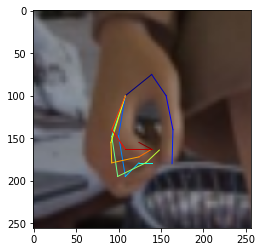

In [63]:
keypoints_coords = detect_keypoints(heatmaps[0].detach().numpy())
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.imshow(img)
plot_hand(keypoints_coords, ax1)